## Libraries

Current active folder

In [ ]:
!pwd

/content


Clone ICI loss repo

In [ ]:
!git clone https://github.com/BrainImageAnalysis/ICI-loss.git
%cd /content/ICI-loss/
# !git pull
# !rm -rf /content/ICI-loss/

import sys
sys.path.insert(0,'/content/ICI-loss/')

Cloning into 'ICI-loss'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 30 (delta 12), reused 23 (delta 8), pack-reused 0
Unpacking objects: 100% (30/30), 189.37 KiB | 4.98 MiB/s, done.
/content/ICI-loss


Install requirements

In [ ]:
!pip install monai
!pip3 install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import libraries

In [ ]:
import nibabel as nib
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from losses.ICI_loss import ICILoss
from losses.dICI_loss import dICILoss
from losses import tools

from monai.losses import DiceLoss

print(torch.__version__)
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print("OK")

2.0.0+cu118
1
0
Tesla T4
OK


## Load example data

Example data (i.e. used in the paper) are located inside folder `example_blobs`. Please change the folder's location accordingly.

In [ ]:
nii_img = nib.load("/content/ICI-loss/example_blobs/label-0.nii.gz")
nii_img_tensor = torch.from_numpy(nii_img.get_fdata())
x, y, z = nii_img_tensor.shape
nii_img_tensor_label = torch.reshape(nii_img_tensor, (1, 1, x, y, z))
print(nii_img_tensor_label.shape)

nii_img = nib.load("/content/ICI-loss/example_blobs/output-0.nii.gz")
nii_img_tensor = torch.from_numpy(nii_img.get_fdata())
x, y, z = nii_img_tensor.shape
nii_img_tensor_output = torch.reshape(nii_img_tensor, (1, 1, x, y, z))
print(nii_img_tensor_output.shape)

torch.Size([1, 1, 197, 233, 189])
torch.Size([1, 1, 197, 233, 189])


Show the example data (label vs. output)

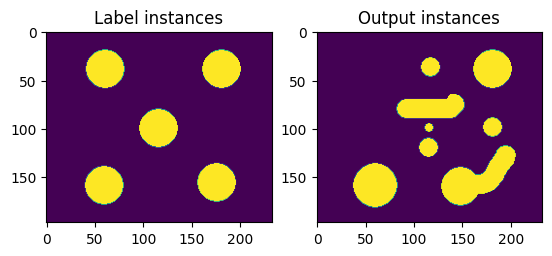

In [ ]:
image = nii_img_tensor_label[0, 0, :, :, 0]
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Label instances")

image = nii_img_tensor_output[0, 0, :, :, 0]
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title("Output instances")
plt.show()

## How to use ICI and dICI losses

Make an instance of ICILoss class. It can be used together with any pixel-wise segmentation losses (e.g. Dice loss, Focal loss, etc.). In this example, losses from MONAI core library are used. Note that the ICILoss have a lot of parameters.

IMPORTANT NOTE: Because the toy data are already binary, we do not need any non-linear function. Please change accordingly to your data.

In [ ]:
## IMPORTANT NOTE: Because the toy data are already binary, we do not need any non-linear function.
## Please read help(ICILoss) for full explanation (i.e. parameters) of the ICI loss.

loss_dice = DiceLoss(
    to_onehot_y=False, 
    sigmoid=False, 
    softmax=False
    )

loss_dice_center = DiceLoss(
    to_onehot_y=False, 
    sigmoid=False, 
    softmax=False
    )

activation="none"
num_out_chn = 1
object_chn = 1
mul_too_many = 50
centroid_offset = 3
num_iterations = 250
max_false_detections = 50
rate_instead_number = False

ici_loss_function = ICILoss(
    loss_function_pixel=loss_dice,
    loss_function_instance=loss_dice_center,
    loss_function_center=loss_dice_center,
    activation=activation,
    num_out_chn=num_out_chn,
    object_chn=object_chn,
    mul_too_many=mul_too_many,
    max_cc_out=max_false_detections,
    num_iterations=num_iterations,
    centroid_offset=centroid_offset,
    rate_instead_number=rate_instead_number,
    instance_wise_loss_no_tp=True,
)

ici_loss_function.print_parameters()


VALUES OF PARAMETERS
 -> loss_function_pixel: DiceLoss()
 -> loss_function_instance: DiceLoss()
 -> loss_function_center: DiceLoss()
 -> num_out_chn: 1
 -> object_chn: 1
 -> spatial_dims: 3
 -> activation: none
 -> reduce: mean
 -> instance_wise_reduce: instance
 -> num_iterations: 250
 -> max_cc_out: 50
 -> min_instance_size: 0
 -> segmentation_threshold: 0.5
 -> centroid_offset: 3
 -> mul_too_many: 50
 -> smoother: 1e-07
 -> instance_wise_loss_no_tp: True
 -> weighted_instance_wise: False
 -> weighted_fdr: False
 -> rate_instead_number: False


Calculate ICI loss

In [ ]:
outputs = nii_img_tensor_output.clone().detach().requires_grad_(True).to("cuda:0")
labels = nii_img_tensor_label.to("cuda:0")

## We can play with the data here (i.e. change the numbers of instances in labels/outputs to 0)
# outputs = outputs * 0.
# labels = labels * 0.

dice_loss = loss_dice(outputs, labels)
print("Dice loss value: ", dice_loss)

seg_pixel, seg_instance, seg_center, seg_fdr, cc_falsed, cc_missed = ici_loss_function(
    outputs, # outputs, zeros
    labels,  # labels, ones
)

print("\nICI Loss")
print("seg_pixel (dice) :", seg_pixel, " - with gradients? ", seg_pixel.requires_grad)
print("seg_instance     :", seg_instance, " - with gradients? ", seg_instance.requires_grad)
print("seg_center       :", seg_center, " - with gradients? ", seg_center.requires_grad)
print("seg_false        :", seg_fdr, " - with gradients? ", seg_fdr.requires_grad)
print("num false        :", cc_falsed, " - with gradients? ", cc_falsed.requires_grad)
print("num missed       :", cc_missed, " - with gradients? ", cc_missed.requires_grad)
print("DONE!")

Dice loss value:  tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)

ICI Loss
seg_pixel (dice) : tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance     : tensor(0.4786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_center       : tensor(0.5793, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_false        : tensor(0.5056, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num false        : tensor(2., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num missed       : tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
DONE!


Make an instance of dICILoss class and calculate the loss.

In [ ]:
dici_loss_function = dICILoss(
    loss_function_pixel=loss_dice,
    loss_function_instance=loss_dice_center,
    loss_function_center=loss_dice_center,
    activation=activation,
    num_out_chn=num_out_chn,
    object_chn=object_chn,
    mul_too_many=mul_too_many,
    max_cc_out=max_false_detections,
    num_iterations=num_iterations,
    centroid_offset=centroid_offset,
    rate_instead_number=rate_instead_number,
    instance_wise_loss_no_tp=True,
)

seg_pixel, seg_instance, seg_instance_out, seg_center, seg_fdr, cc_falsed, cc_missed = dici_loss_function(
    outputs, # outputs, zeros
    labels,  # labels, ones
)

print("dICI Loss")
print("seg_pixel (dice) :", seg_pixel, " - with gradients? ", seg_pixel.requires_grad)
print("seg_instance     :", seg_instance, " - with gradients? ", seg_instance.requires_grad)
print("seg_instance_out :", seg_instance_out, " - with gradients? ", seg_instance_out.requires_grad)
print("seg_center       :", seg_center, " - with gradients? ", seg_center.requires_grad)
print("seg_false        :", seg_fdr, " - with gradients? ", seg_fdr.requires_grad)
print("num false        :", cc_falsed, " - with gradients? ", cc_falsed.requires_grad)
print("num missed       :", cc_missed, " - with gradients? ", cc_missed.requires_grad)
print("DONE!")

dICI Loss
seg_pixel (dice) : tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance     : tensor(0.4786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance_out : tensor(0.6545, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_center       : tensor(0.5793, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_false        : tensor(0.5056, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num false        : tensor(2., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num missed       : tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
DONE!


We also can pre-compute the connected components (CC) of manual labels to reduce the computing time. The pre-computed CC image can be passed into the instance of ICILoss and dICILoss classes. Note that in this example, the CC of manual label is computed before the calculation of ICI and dICI losses.

In [ ]:
cc_labels = tools.connected_components(labels, 350, 3)

seg_pixel, seg_instance, seg_center, seg_fdr, cc_falsed, cc_missed = ici_loss_function(
    outputs, # outputs, zeros
    labels,  # labels, ones
    cc_labels
)

print("ICI Loss (with pre-computed connected components for labels)")
print("seg_pixel (dice) :", seg_pixel, " - with gradients? ", seg_pixel.requires_grad)
print("seg_instance     :", seg_instance, " - with gradients? ", seg_instance.requires_grad)
print("seg_center       :", seg_center, " - with gradients? ", seg_center.requires_grad)
print("seg_false        :", seg_fdr, " - with gradients? ", seg_fdr.requires_grad)
print("num false        :", cc_falsed, " - with gradients? ", cc_falsed.requires_grad)
print("num missed       :", cc_missed, " - with gradients? ", cc_missed.requires_grad)
print("DONE!")


seg_pixel, seg_instance, seg_instance_out, seg_center, seg_fdr, cc_falsed, cc_missed = dici_loss_function(
    outputs, # outputs, zeros
    labels,  # labels, ones
    cc_labels
)

print("\nDICILosss (with pre-computed connected components for labels)")
print("seg_pixel (dice) :", seg_pixel, " - with gradients? ", seg_pixel.requires_grad)
print("seg_instance     :", seg_instance, seg_instance.requires_grad)
print("seg_instance_out :", seg_instance_out, seg_instance_out.requires_grad)
print("seg_center       :", seg_center, seg_center.requires_grad)
print("seg_false        :", seg_fdr, seg_fdr.requires_grad)
print("num false        :", cc_falsed, cc_falsed.requires_grad)
print("num missed       :", cc_missed, cc_missed.requires_grad)
print("DONE!")

ICI Loss (with pre-computed connected components for labels)
seg_pixel (dice) : tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance     : tensor(0.4786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_center       : tensor(0.5793, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_false        : tensor(0.5056, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num false        : tensor(2., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num missed       : tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
DONE!

DICILosss (with pre-computed connected components for labels)
seg_pixel (dice) : tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance     : tenso

We also can change any values of ICILoss and dICILoss parameters on the fly by using internal function named `edit_parameters`.

In [ ]:
seg_pixel, seg_instance, seg_center, seg_fdr, cc_falsed, cc_missed = ici_loss_function(
    outputs, # outputs, zeros
    labels,  # labels, ones
)

print("ICI Loss")
print("seg_pixel (dice) :", seg_pixel, " - with gradients? ", seg_pixel.requires_grad)
print("seg_instance     :", seg_instance, " - with gradients? ", seg_instance.requires_grad)
print("seg_center       :", seg_center, " - with gradients? ", seg_center.requires_grad)
print("seg_false        :", seg_fdr, " - with gradients? ", seg_fdr.requires_grad)
print("num false        :", cc_falsed, " - with gradients? ", cc_falsed.requires_grad)
print("num missed       :", cc_missed, " - with gradients? ", cc_missed.requires_grad)
print("DONE!")

ici_loss_function.edit_parameters(rate_instead_number=True)
seg_pixel, seg_instance, seg_center, seg_fdr, cc_falsed, cc_missed = ici_loss_function(
    outputs, # outputs, zeros
    labels,  # labels, ones
    cc_labels
)

print("\nICI Loss (with rates of false and missed instances instead of numbers)")
print("seg_pixel (dice) :", seg_pixel, " - with gradients? ", seg_pixel.requires_grad)
print("seg_instance     :", seg_instance, " - with gradients? ", seg_instance.requires_grad)
print("seg_center       :", seg_center, " - with gradients? ", seg_center.requires_grad)
print("seg_false        :", seg_fdr, " - with gradients? ", seg_fdr.requires_grad)
print("rate false       :", cc_falsed, " - with gradients? ", cc_falsed.requires_grad)
print("rate missed      :", cc_missed, " - with gradients? ", cc_missed.requires_grad)
print("DONE!")

ICI Loss
seg_pixel (dice) : tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance     : tensor(0.4786, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_center       : tensor(0.5793, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_false        : tensor(0.5056, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num false        : tensor(2., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
num missed       : tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
DONE!

ICI Loss (with rates of false and missed instances instead of numbers)
seg_pixel (dice) : tensor(0.4587, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)  - with gradients?  True
seg_instance     : tensor(0.4786, device='cuda:0', dtype=torch.floa

## Full information of ICILoss

Information of ICI loss can be seen by calling `help(ICILoss)`.

In [ ]:
help(ICILoss)

Help on class ICILoss in module losses.ICI_loss:

class ICILoss(torch.nn.modules.loss._Loss)
 |  ICILoss(loss_function_pixel, loss_function_instance, loss_function_center, activation='sigmoid', num_out_chn=1, object_chn=1, spatial_dims=3, reduce_segmentation='mean', instance_wise_reduce='instance', num_iterations=350, segmentation_threshold=0.5, max_cc_out=50, mul_too_many=50, min_instance_size=0, centroid_offset=5, smoother=1e-07, instance_wise_loss_no_tp=True, rate_instead_number=False, weighted_instance_wise=False, weighted_fdr=False)
 |  
 |  Compute Instance-wise and Center-of-Instance (ICI) segmentation loss between two tensors.
 |  The data `outputs` (BNHW[D] where N is number of classes) is compared with ground truth `labels` (BNHW[D]).
 |  
 |  For a two-class segmentation problem (i.e. background and foreground classes), either sigmoid or softmax
 |  non-linear function can be called within the function loss (set "activation = 'sigmoid'" or "activation = 'softmax'",
 |  respe